# **Face Recognition**

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow
tensorflow.__version__

'2.2.0'

**Mount Google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Change current working directory to project folder**

In [4]:
import os
os.chdir('/content/drive/My Drive/AI')

**Extract Aligned Face Dataset from Pinterest.zip**

In [5]:
from zipfile import ZipFile

with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as z:
    z.extractall()

**Function to load images**

In [6]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

***Define function to load image***

In [7]:
import cv2
def load_image(path):
  img = cv2.imread(path, 1)
  return img[...,::-1]

**Load a sample image**

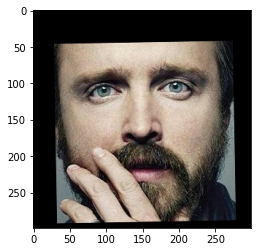

In [8]:
import matplotlib.pyplot as plt
image = load_image(metadata[10].image_path())
plt.imshow(image)

***VGG Face model***

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
  model = Sequential()
  model.add(ZeroPadding2D((1,1), input_shape=(224,224,3)))
  model.add(Convolution2D(64, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))

  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128,(3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))

  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))

  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))

  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3,3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))

  model.add(Convolution2D(4096, (7,7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1,1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1,1)))
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

**Load the model**

In [10]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5') # Loading weight file "vgg_face_weight.h5"
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

**Get vgg_face_descriptor**

In [11]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs=model.layers[-2].output)

***Generate embeddings for each image in the dataset***

In [12]:
img_path = metadata[0].image_path()
img = load_image(img_path)

img = (img/255.).astype(np.float32)

img = cv2.resize(img, dsize=(224,224))
print(img.shape)

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)


(224, 224, 3)
(2622,)



*   The image is of shape 224X224 with 3 channels.ist item
*   The embedding vector is of shape 2622X1


**Generate embeddings for all images**

In [13]:
embeddings = np.zeros((metadata.shape[0],2622))

for i in range(len(metadata)):
  img_path = metadata[i].image_path()
  # iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings
  try:
    img = load_image(img_path)
    img = (img/255.).astype(np.float32)
    img = cv2.resize(img, dsize=(224,224))
    # obtain embedding vector for image
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  # If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622
  except:
    embeddings[i] = np.zeros((2622,))

***Function to calculate distance between given 2 pair of images***

In [14]:
def distance(emb1, emb2):
  return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

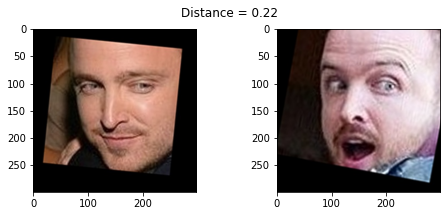

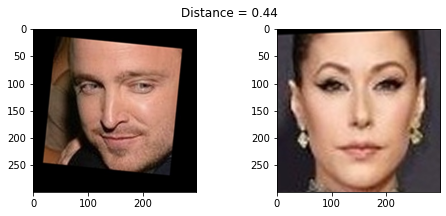

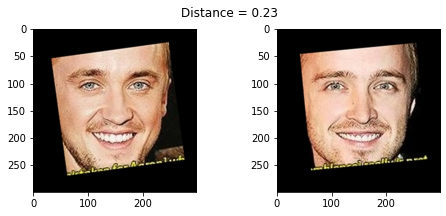

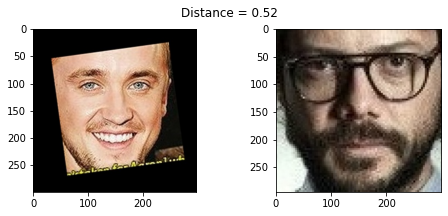

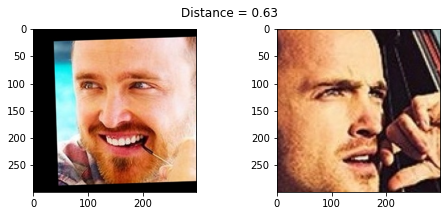

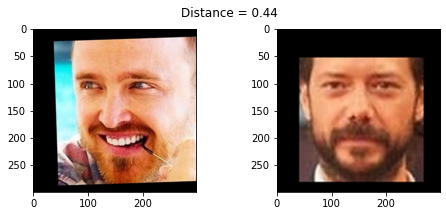

In [15]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
  plt.figure(figsize=(8,3))
  plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
  plt.subplot(121)
  plt.imshow(load_image(metadata[idx1].image_path()))
  plt.subplot(122)
  plt.imshow(load_image(metadata[idx2].image_path()))

show_pair(2,3)
show_pair(2,180)
show_pair(30,31)
show_pair(30,100)
show_pair(70,72)
show_pair(70,115)

***Create train and test sets***

In [16]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

### Encode the Labels (5 marks)
- Encode the targets
- Use LabelEncoder

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoder.fit(y_test)

# Numerical encoding of identities
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
targets[101]

'pins_Alvaro Morte'

Standardize the feature values
Scale the features using StandardScaler

In [18]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


### Reduce dimensions using PCA 
- Reduce feature dimensions using Principal Component Analysis

In [19]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)

pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [20]:
print("shape of X_train scaled:", X_train_scaled.shape)
print("shape of X_test scaled:", X_test_scaled.shape)
print("Shape of X_train PCA:", X_train_pca.shape)
print("Shape of X_test PCA:", X_test_pca.shape)
print("Shape of y_train:", y_train.shape)

shape of X_train scaled: (9573, 2622)
shape of X_test scaled: (1197, 2622)
Shape of X_train PCA: (9573, 901)
Shape of X_test PCA: (1197, 901)
Shape of y_train: (9573,)


After PCA, the number of features reduces from 2622 to 901

### Build a Classifier (5 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC()

svc.fit(X_train_scaled, y_train)

acc_svc = accuracy_score(y_test, svc.predict(X_test_scaled))

print(acc_svc)

0.9640768588137009


In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#svc = SVC(C=1000.0, kernel='rbf', gamma=0.001, class_weight='balanced')
svc = SVC()
svc.fit(X_train_pca, y_train)

acc_svc = accuracy_score(y_test, svc.predict(X_test_pca))

print(acc_svc)

0.9440267335004177


Before PCA the accuracy score was 0.96 and after PCA the accuracy score is 0.94. There is a 2% reduction in accuracy but features has been reduced from 2622 to 901.

### Test results
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

Running the test with scaled data

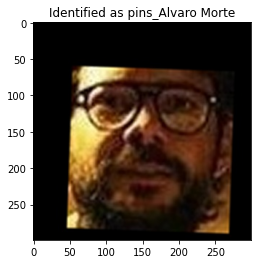

In [26]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([X_test_scaled[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0] 
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

Running the test with data after PCA

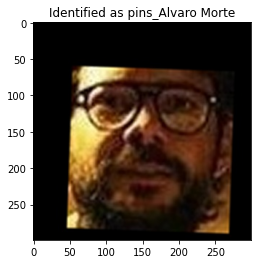

In [24]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([X_test_pca[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0] 
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

From above we can see that the model is able to identify the image correctly.